In [14]:
import gdal
import numpy as np
import pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import torch
from glob import glob
import shapely
import random
from tqdm import tqdm
from collections import Counter
from pybob.GeoImg import GeoImg
import osr
from pybob.image_tools import create_mask_from_shapefile
import gc
import imageio
import time
import shutil
import os
import warnings
warnings.filterwarnings('ignore')

In [58]:
def get_mask(maskshp,geotrf,shape,p='4326'):
    img=np.zeros((shape[0],shape[1]))
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    
    trf=(geotrf[0], geotrf[1], geotrf[2], geotrf[3], geotrf[4], geotrf[5])
    drv = gdal.GetDriverByName('MEM')
    dst = drv.Create('', shape[1], shape[0], 1, gdal.GDT_UInt16)

    sp = dst.SetProjection(proj)
    sg = dst.SetGeoTransform(trf)

    wa = dst.GetRasterBand(1).WriteArray(img)
    del wa, sg, sp
    img_bob = GeoImg(dst)
    mask = create_mask_from_shapefile(img_bob, maskshp)
    return mask
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def tif_save_bands(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[2],img.shape[1],img.shape[0],6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    for i in range(img.shape[0]):
        new_img.GetRasterBand(i+1).WriteArray(img[i,:,:])
    new_img.FlushCache()
    del new_img
def tif_save(img,save_name,trf,p='4326'):
    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(save_name,img.shape[1],img.shape[0],1,6,['COMPRESS=LZW','BIGTIFF=YES'])
    new_img.SetGeoTransform(trf)
    
    if p=='4326':
        sref = osr.SpatialReference()
        sref.ImportFromEPSG(4326)
        proj = sref.ExportToWkt()
    else:
        proj=p
    new_img.SetProjection(proj)
    new_img.GetRasterBand(1).SetNoDataValue(0)
    new_img.GetRasterBand(1).WriteArray(img)
    new_img.FlushCache()
    del new_img

# 分区mask

In [301]:
glob('/home/hk/python_script/Ukraine/data/UNOSAT/Lysychansk_CDA_20220921/*.shp')

['/home/hk/python_script/Ukraine/data/UNOSAT/Lysychansk_CDA_20220921/Lysychansk_boundaries.shp',
 '/home/hk/python_script/Ukraine/data/UNOSAT/Lysychansk_CDA_20220921/Lysychansk_CDA_20220921.shp']

In [307]:
gpd.read_file('/home/hk/python_script/Ukraine/data/UNOSAT/Lysychansk_CDA_20220921/Lysychansk_CDA_20220921.shp')

,SiteID,SensorDate,SensorID,Confidence,Main_Damag,SensorDa_1,SensorID_2,Confiden_1,Main_Dam_1,Damage_Sta,...,Damage_S_4,Grouped_Da,FieldValid,Notes,Settlement,Neighborho,EventCode,Analyst,Main_Dam_5,geometry
0,26,2022-09-21,28,2,4,None,0,0,0,0,...,0,1,0,None,Lysychansk,None,CE20220223UKR,219,0,POINT (4283778.125 6250557.354)
1,26,2022-09-21,28,1,3,None,0,0,0,0,...,0,1,0,Supermarket,Lysychansk,None,CE20220223UKR,219,0,POINT (4283617.128 6250550.924)
2,26,2022-09-21,28,3,4,None,0,0,0,0,...,0,1,0,None,Lysychansk,None,CE20220223UKR,219,0,POINT (4284165.583 6250781.036)
3,26,2022-09-21,28,1,3,None,0,0,0,0,...,0,1,0,None,Lysychansk,None,CE20220223UKR,219,0,POINT (4283845.973 6250624.371)
4,26,2022-09-21,28,2,3,None,0,0,0,0,...,0,1,0,None,Lysychansk,None,CE20220223UKR,219,0,POINT (4283868.766 6250609.508)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,26,2022-09-21,28,1,3,None,0,0,0,0,...,0,1,0,None,Lysychansk,None,CE20220223UKR,219,0,POINT (4282349.666 6257713.380)
1400,26,2022-09-21,28,2,4,None,0,0,0,0,...,0,1,0,None,Lysychansk,None,CE20220223UKR,219,0,POINT (4279941.378 6260018.842)
1401,26,2022-09-21,28,3,3,None,0,0,0,0,...,0,1,0,None,Lysychansk,None,CE20220223UKR,219,0,POINT (4279424.939 6260376.964)
1402,26,2022-09-21,28,2,3,None,0,0,0,0,...,0,1,0,None,Lysychansk,None,CE20220223UKR,219,0,POINT (4268919.626 6262722.496)


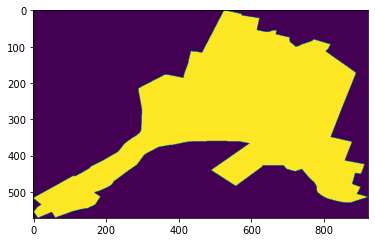

In [59]:
cities=['Sievierodoetsk','Rubizhne','volnovskha']
fs=glob(f'/data4/Ukraine_img/{cities[2]}/*')
fs.sort()
f=fs[0]
ds=gdal.Open(f)
trf=ds.GetGeoTransform()
shape=ds.ReadAsArray().shape
shps=['/home/hk/python_script/Ukraine/data/UNOSAT/Sievierodonetsk_CDA_20220725/Sievierodoetsk_boundary.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/Rubizhne_CDA_20220709/Rubizhne_boundary.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/volnovakha.shp']
mask=get_mask(shps[2],trf,[shape[1],shape[2]],p='4326')
plt.imshow(mask)

In [35]:
# labels_date={'A':['20210910'],
#                 'A-B':['20220319','20220324','20220329','20220408','20220423','20220508','20220523','20220612','20220617','20220627','20220702','20220707','20220717'],
#                 'B':[],
#                 'B-Z':['20220727','20220801','20220806','20220811','20220831','20220905','20220920']}
# points_path='/home/hk/python_script/Ukraine/data/UNOSAT/Sievierodonetsk_CDA_20220725/Sievierodonetsk_B_2022-07-25.shp'

# labels_date={'A':['20210910'],
#                 'A-B':['20220319','20220324','20220329','20220423','20220508','20220523','20220612','20220617','20220627','20220702','20220707','20220717'],
#                 'B':[],
#                 'B-Z':['20220727','20220801','20220806','20220831','20220905','20220920']}
# points_path='/home/hk/python_script/Ukraine/data/UNOSAT/Rubizhne_CDA_20220709/Rubizhne_B_2022-07-09.shp'

labels_date={'A':['20210910'],
                'A-B':['20220314','20220319','20220324','20220329','20220403','20220428','20220503'],
                'B':[],
                'B-Z':['20220508','20220513','20220528','20220602','20220607','20220612','20220617','20220622']}
points_path='/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07.shp'

In [34]:
ps_path=['/home/hk/python_script/Ukraine/data/UNOSAT/Sievierodonetsk_CDA_20220725/Sievierodonetsk_B_2022-07-25.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/Rubizhne_CDA_20220709/Rubizhne_B_2022-07-09.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07.shp']
/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_25April2022_CDA/
/home/hk/python_script/Ukraine/data/UNOSAT/LivoberezhnyiandZhovtnevyi_0507-08-12/
f=gpd.read_file(ps_path[0])
print('S',len(f[f['DmgCls']=='Destroyed']))
f=gpd.read_file(ps_path[1])
print('R',len(f[f['DmgCls']=='Destroyed']))
f=gpd.read_file(ps_path[2])
print('V',len(f[f['DmgCls']=='Destroyed']))

S 92
R 488
V 264


In [31]:
# points_path='/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_CDA_20220530.shp'
# points=gpd.read_file(points_path)
# points=points.to_crs(4326)
# points=points[points['Main_Damag']<4.5]
# k={1:'Destroyed',2:'Severe Damage',3:'Moderate Damage',4:'Possible Damage'}
# DmgCls=[k[i] for i in list(points['Main_Damag'])]
# points=gpd.GeoDataFrame({'a':list(range(len(points))),
#                         'SiteID':['None']*len(points),
#                         'SensDt':['2022-05-07']*len(points),
#                         'DmgCls':DmgCls,
#                         'StlmtNme':['Volnovakha']*len(points),
#                         'geometry':list(points['geometry'])})
# points.to_file('/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07.shp')


In [30]:
points

,a,SiteID,SensDt,DmgCls,StlmtNme,geometry
0,0,None,2022-05-07,Severe Damage,Rubizhne,POINT (37.51120 47.61480)
1,1,None,2022-05-07,Severe Damage,Rubizhne,POINT (37.51112 47.61458)
2,2,None,2022-05-07,Severe Damage,Rubizhne,POINT (37.51095 47.61429)
3,3,None,2022-05-07,Severe Damage,Rubizhne,POINT (37.50954 47.61475)
4,4,None,2022-05-07,Severe Damage,Rubizhne,POINT (37.50963 47.61461)
...,...,...,...,...,...,...
974,974,None,2022-05-07,Severe Damage,Rubizhne,POINT (37.49163 47.59390)
975,975,None,2022-05-07,Severe Damage,Rubizhne,POINT (37.49224 47.59255)
976,976,None,2022-05-07,Moderate Damage,Rubizhne,POINT (37.49811 47.58869)
977,977,None,2022-05-07,Moderate Damage,Rubizhne,POINT (37.49846 47.58838)


In [21]:
def resample(input_path,output_path):
    ds=gdal.Open(input_path)
    width=ds.RasterXSize
    height=ds.RasterYSize
    transform=ds.GetGeoTransform()
    width=int(width/2)
    height=int(height/2)


    driver=gdal.GetDriverByName('GTiff')
    new_img=driver.Create(output_path,
                                   width,height,6,6,['COMPRESS=LZW','BIGTIFF=YES'])
    transform_new=(transform[0]+transform[1],transform[1]*2,transform[2],transform[3]+transform[5],transform[4],transform[5]*2)
    new_img.SetGeoTransform(transform_new)
    new_img.SetProjection(ds.GetProjection())
    for i in range(5,11):
        band = ds.GetRasterBand(i)
        data = band.ReadAsArray(buf_xsize=width,buf_ysize=height)

        new_img.GetRasterBand(i-4).SetNoDataValue(0)
        new_img.GetRasterBand(i-4).WriteArray(data)
    new_img.FlushCache()
    print('重采样完成：',input_path)
    del ds
    del new_img
    del data

In [19]:
fs=glob('/data4/Ukraine_img/volnovskha/*')
fs.sort()
for f in fs:
    ds=gdal.Open(f)
    img=ds.ReadAsArray()
    print(img.shape)

(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [62]:
# tif_save(img,save_name,trf,p='4326')
for f in fs:
    ds=gdal.Open(f)
    img=ds.ReadAsArray()
    trf=ds.GetGeoTransform()
    tif_save_bands(img[:,:-1,:-1],f,trf)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

In [22]:
fs=glob('/data4/Ukraine_img/volnovskha/*')
fs.sort()
for f in fs:
    print(f.replace('.tif','_bandother.tif'))
    resample(f,f.replace('.tif','_bandother.tif'))

/data4/Ukraine_img/volnovskha/20210910T082601_20210910T083119_T37TCN_bandother.tif
重采样完成： /data4/Ukraine_img/volnovskha/20210910T082601_20210910T083119_T37TCN.tif
/data4/Ukraine_img/volnovskha/20220309T082801_20220309T083304_T37TCN_bandother.tif
重采样完成： /data4/Ukraine_img/volnovskha/20220309T082801_20220309T083304_T37TCN.tif
/data4/Ukraine_img/volnovskha/20220314T082719_20220314T083610_T37TCN_bandother.tif
重采样完成： /data4/Ukraine_img/volnovskha/20220314T082719_20220314T083610_T37TCN.tif
/data4/Ukraine_img/volnovskha/20220319T082651_20220319T083304_T37TCN_bandother.tif
重采样完成： /data4/Ukraine_img/volnovskha/20220319T082651_20220319T083304_T37TCN.tif
/data4/Ukraine_img/volnovskha/20220324T082609_20220324T083426_T37TCN_bandother.tif
重采样完成： /data4/Ukraine_img/volnovskha/20220324T082609_20220324T083426_T37TCN.tif
/data4/Ukraine_img/volnovskha/20220329T082601_20220329T083216_T37TCN_bandother.tif
重采样完成： /data4/Ukraine_img/volnovskha/20220329T082601_20220329T083216_T37TCN.tif
/data4/Ukraine_img/vol

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

重采样完成： /data4/Ukraine_img/volnovskha/20220602T082559_20220602T082807_T37TCN.tif
/data4/Ukraine_img/volnovskha/20220607T082611_20220607T083435_T37TCN_bandother.tif
重采样完成： /data4/Ukraine_img/volnovskha/20220607T082611_20220607T083435_T37TCN.tif
/data4/Ukraine_img/volnovskha/20220612T082609_20220612T082840_T37TCN_bandother.tif
重采样完成： /data4/Ukraine_img/volnovskha/20220612T082609_20220612T082840_T37TCN.tif
/data4/Ukraine_img/volnovskha/20220617T082611_20220617T083253_T37TCN_bandother.tif
重采样完成： /data4/Ukraine_img/volnovskha/20220617T082611_20220617T083253_T37TCN.tif
/data4/Ukraine_img/volnovskha/20220622T082609_20220622T082834_T37TCN_bandother.tif
重采样完成： /data4/Ukraine_img/volnovskha/20220622T082609_20220622T082834_T37TCN.tif


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [23]:
for f in fs:
    print(gdal.Open(f).ReadAsArray().shape)
for f in fs:
    print(gdal.Open(f.replace('.tif','_bandother.tif')).ReadAsArray().shape)

(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(10, 572, 922)
(6, 286, 461)
(6, 286, 461)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as 

(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)
(6, 286, 461)


# 转换图像为Patch

In [37]:
def read_img(path):
    ds=gdal.Open(path)
    trf=ds.GetGeoTransform()
    img=ds.ReadAsArray()
    return {'trf':trf,'img':img}
def get_patch(data,size):
    img=data['img']
    trf=data['trf']
    shape=img.shape
    img=np.pad(img,((0,0),(0,size-shape[1]%size),(0,size-shape[2]%size)),'constant',constant_values=0)
    shape=img.shape
    img=img.reshape([shape[0],int(shape[1]/size),-1,shape[2]])
    shape=img.shape
    img=img.reshape([shape[0],shape[1],shape[2],int(shape[3]/size),-1])
    return {'img':img.transpose((0,1,3,2,4)),'trf':(trf[0]-trf[1]/2,trf[1]*size,trf[2],trf[3]-trf[5]/2,trf[4],trf[5]*size)}
size=6
fs10=glob(f'/data4/Ukraine_img/{cities[2]}/*')
fs10=[i for i in fs10 if i[-5:]!='r.tif']
fs10.sort()
fs10
img_pathes=fs10
# img_pathes=['/data2/Syria_img/Raqqa_enhance-A-B-4_20130213_treated.tif']
print(img_pathes)

for path in img_pathes:
    # try:    
    
    print(path)
    data=read_img(path)
    ddata=read_img(path.replace('.tif','_bandother.tif'))
    for i in range(4):
        data['img'][i,:,:][mask==0]=0
    print(data['img'].shape)
    data2=get_patch(data,6)
    ddata2=get_patch(ddata,3)
    print(data2['img'].shape)
    print(data2['trf'])
    d=data2['img'][:4].astype(np.int16)
    dd=ddata2['img'].astype(np.int16)
    info={'readme':'trf分别为patch左上角坐标(不是左上角像元的中心坐标)和patch的长度',
    'trf':data2['trf'],'shape':[data['img'].shape,d.shape],'img10':d,'img20':dd}

    # np.save(path.replace('.tif',f'_size_{size}.npy'),d)
    print('max:',d.max())
    torch.save(info,path.replace('.tif',f'_size_{size}_{cities[2]}_info.pth'))
    del data,data2,d
    gc.collect()
    # except:
    #         print('ERROR',path)

['/data4/Ukraine_img/volnovskha/20210910T082601_20210910T083119_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220309T082801_20220309T083304_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220314T082719_20220314T083610_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220319T082651_20220319T083304_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220324T082609_20220324T083426_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220329T082601_20220329T083216_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220403T082559_20220403T083553_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220428T082611_20220428T083305_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220503T082559_20220503T083512_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220508T082611_20220508T083304_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220513T082559_20220513T082940_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220528T082611_20220528T083641_T37TCN.tif', '/data4/Ukraine_img/volnovskha/20220602T082559_20220602T082807_T37TCN.tif', '/data4/Ukr

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


/data4/Ukraine_img/volnovskha/20220503T082559_20220503T083512_T37TCN.tif
(10, 572, 922)
(10, 96, 154, 6, 6)
(37.440298821882855, 0.0005389891704717128, 0.0, 47.62279239890605, 0.0, -0.0005389891704717128)
max: 15376
/data4/Ukraine_img/volnovskha/20220508T082611_20220508T083304_T37TCN.tif
(10, 572, 922)
(10, 96, 154, 6, 6)
(37.440298821882855, 0.0005389891704717128, 0.0, 47.62279239890605, 0.0, -0.0005389891704717128)
max: 11944


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


/data4/Ukraine_img/volnovskha/20220513T082559_20220513T082940_T37TCN.tif
(10, 572, 922)
(10, 96, 154, 6, 6)
(37.440298821882855, 0.0005389891704717128, 0.0, 47.62279239890605, 0.0, -0.0005389891704717128)
max: 11144
/data4/Ukraine_img/volnovskha/20220528T082611_20220528T083641_T37TCN.tif
(10, 572, 922)
(10, 96, 154, 6, 6)
(37.440298821882855, 0.0005389891704717128, 0.0, 47.62279239890605, 0.0, -0.0005389891704717128)
max: 10064


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


/data4/Ukraine_img/volnovskha/20220602T082559_20220602T082807_T37TCN.tif
(10, 572, 922)
(10, 96, 154, 6, 6)
(37.440298821882855, 0.0005389891704717128, 0.0, 47.62279239890605, 0.0, -0.0005389891704717128)
max: 7488
/data4/Ukraine_img/volnovskha/20220607T082611_20220607T083435_T37TCN.tif
(10, 572, 922)
(10, 96, 154, 6, 6)
(37.440298821882855, 0.0005389891704717128, 0.0, 47.62279239890605, 0.0, -0.0005389891704717128)


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


max: 9496
/data4/Ukraine_img/volnovskha/20220612T082609_20220612T082840_T37TCN.tif
(10, 572, 922)
(10, 96, 154, 6, 6)
(37.440298821882855, 0.0005389891704717128, 0.0, 47.62279239890605, 0.0, -0.0005389891704717128)
max: 9152


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


/data4/Ukraine_img/volnovskha/20220617T082611_20220617T083253_T37TCN.tif
(10, 572, 922)
(10, 96, 154, 6, 6)
(37.440298821882855, 0.0005389891704717128, 0.0, 47.62279239890605, 0.0, -0.0005389891704717128)
max: 13160
/data4/Ukraine_img/volnovskha/20220622T082609_20220622T082834_T37TCN.tif
(10, 572, 922)
(10, 96, 154, 6, 6)
(37.440298821882855, 0.0005389891704717128, 0.0, 47.62279239890605, 0.0, -0.0005389891704717128)
max: 6640


Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [38]:
fs=glob(f'/data4/Ukraine_img/{cities[2]}/*info.pth')
fs.sort()
fs

['/data4/Ukraine_img/volnovskha/20210910T082601_20210910T083119_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220309T082801_20220309T083304_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220314T082719_20220314T083610_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220319T082651_20220319T083304_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220324T082609_20220324T083426_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220329T082601_20220329T083216_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220403T082559_20220403T083553_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220428T082611_20220428T083305_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220503T082559_20220503T083512_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220508T082611_20220508T083304_T37TCN_size_6_volnovskha_info.pth',


# 制作patch的label

In [40]:
def get_dam_mask(point,patch_file,weight):
    trf=torch.load(patch_file)['trf']
    shape=torch.load(patch_file)['shape'][1]
    p_coor=[shapely.geometry.mapping(list(point)[i])['coordinates'] for i in range(len(point))]
    mask=np.zeros((shape[1],shape[2]))
    p_x_y=[[int((i[0]-trf[0])/trf[1]),int((i[1]-trf[3])/trf[5])] for i in p_coor]
    for i in p_x_y:
        try:
            mask[i[1],i[0]]+=weight
        except:
            pass
    return mask
def get_mask(points_path,patch_path):
    n=points_path.split("_")[-2]
    df=gpd.read_file(points_path)
    print(len(df))
    point_num={}
    point=df[df['DmgCls']=='Destroyed']['geometry']
    point_num['destroyed']=len(point)
    print('destroyed:',len(point))
    mask_destroyed=get_dam_mask(point,patch_path,1)
    point=df[df['DmgCls']=='Severe Damage']['geometry']
    point_num['severe']=len(point)
    print('Severe Damage:',len(point))
    mask_severe=get_dam_mask(point,patch_path,1)
    point=df[df['DmgCls']=='Moderate Damage']['geometry']
    point_num['moderate']=len(point)
    print('Moderate Damage:',len(point))
    mask_moderate=get_dam_mask(point,patch_path,1)

    mask=mask_destroyed*6+mask_severe*3+mask_moderate
    date=df['SensDt'][0]
    print(f'{n}  {date}得分',dict(Counter(list(mask.flatten()))))
    mask_type=np.zeros(mask.shape)
    mask_type[mask>0]=1
    mask_type[mask>=6]=2
    print(f'{date}损毁类型',Counter(list(mask_type.flatten())))
    all_mask=[mask_destroyed,mask_severe,mask_moderate,mask,mask_type]
    info='5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
    result={'info':info,'point_num':point_num,'mask':all_mask}
    return result

In [39]:
points_path
# points_path='/home/hk/python_script/Ukraine/data/UNOSAT/Sievierodonetsk_CDA_20220725/Sievierodonetsk_B_2022-07-25.shp'

'/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07.shp'

In [41]:

patch_path='/data4/Ukraine_img/volnovskha/20210910T082601_20210910T083119_T37TCN_size_6_volnovskha_info.pth'
result=get_mask(points_path,patch_path)
save_path=points_path.replace('.shp','_size_6_dammask.pth.tar')
torch.save(result,save_path)
print('save:',save_path)
print('__________________________SAVE SUCCESS__________________________')

# for point_path in points_list:
#     patch_path='/data4/Ukraine_img/U_bandother/20210910T082601_20210910T083119_T37TCN_cut_reprojection_size_3_info.pth'
#     result=get_mask(point_path,patch_path)
#     torch.save(result,point_path.replace('.shp','_size_3_dammask.pth.tar'))
#     print('__________________________SAVE SUCCESS__________________________')


979
destroyed: 264
Severe Damage: 541
Moderate Damage: 66
B  2022-05-07得分 {0.0: 14155, 3.0: 298, 9.0: 41, 12.0: 28, 6.0: 181, 21.0: 5, 15.0: 5, 27.0: 2, 4.0: 5, 1.0: 43, 18.0: 6, 10.0: 2, 2.0: 4, 14.0: 1, 39.0: 1, 7.0: 2, 24.0: 2, 8.0: 1, 19.0: 1, 13.0: 1}
2022-05-07损毁类型 Counter({0.0: 14155, 1.0: 350, 2.0: 279})
save: /home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07_size_6_dammask.pth.tar
__________________________SAVE SUCCESS__________________________


# 制作样本

In [43]:
# masks={
#     'A':None,
#     'B':glob(f'/data2/Syria_img/{city}_B_*_treated_size_120_dammask.pth.tar')[0],
#     'C':glob(f'/data2/Syria_img/{city}_C_*_treated_size_120_dammask.pth.tar')[0],
#     'D':glob(f'/data2/Syria_img/{city}_D_*_treated_size_120_dammask.pth.tar')[0],
#     'Z':None
# }


def get_samples(pre_patch,post_patch,dammask_after,dammask_now,dammask_before):
        # if pre_patch[0].shape!=post_patch[0].shape:
        #         raise('SHAPE ERROR')
        if pre_patch[0].shape[0]!=4 or post_patch[0].shape[0]!=4:
                raise
        if pre_patch[1].shape[0]!=6 or post_patch[1].shape[0]!=6:
                raise
                               
        shape=pre_patch[0].shape
        print(shape)
        zz=np.zeros((shape[1],shape[2]))
        samples=[]
        if dammask_now is not None:
                for x in range(shape[1]):
                        for y in range(shape[2]):
                                
                                if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                        continue
                                else:
                                        samples.append([[x,y],[None,[int(i[x,y]) for i in dammask_now['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                        zz[x,y]=1
        else:
                if dammask_before is None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if dammask_after['mask'][0][x,y]==0:
                                                        samples.append([[x,y],[None,[int(i[x,y]) for i in dammask_after['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                if dammask_after is None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if dammask_before['mask'][0][x,y]>0:
                                                        samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],None],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                if dammask_before is not None and dammask_after is not None:
                        for x in range(shape[1]):
                                for y in range(shape[2]):
                                        
                                        if (pre_patch[0][:,x,y]==0).any() or (post_patch[0][:,x,y]==0).any() or (pre_patch[1][:,x,y]==0).any() or (post_patch[1][:,x,y]==0).any():
                                                continue
                                        else:
                                                if (dammask_after['mask'][0][x,y]>0 and dammask_before['mask'][0][x,y]>0) or (dammask_after['mask'][0][x,y]==0 and dammask_before['mask'][0][x,y]==0):
                                                        samples.append([[x,y],[[int(i[x,y]) for i in dammask_before['mask']],[int(i[x,y]) for i in dammask_after['mask']]],np.concatenate([pre_patch[0][:,x,y],post_patch[0][:,x,y]],axis=0),np.concatenate([pre_patch[1][:,x,y],post_patch[1][:,x,y]],axis=0)])
                                                        zz[x,y]=1
                                        
        return samples,zz

In [61]:
# dammasks_path={'Rubizhne':{'A':None,'B':'/home/hk/python_script/Ukraine/data/UNOSAT/Rubizhne_CDA_20220709/Rubizhne_B_2022-07-09_size_6_dammask.pth.tar','Z':None}}
dammasks_path={'volnovskha':{'A':None,'B':'/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07_size_6_dammask.pth.tar','Z':None}}
dammasks_path

{'volnovskha': {'A': None,
  'B': '/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07_size_6_dammask.pth.tar',
  'Z': None}}

In [48]:
fs=glob('/data4/Ukraine_img/volnovskha/*.pth')
fs.sort()
fs

['/data4/Ukraine_img/volnovskha/20210910T082601_20210910T083119_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220309T082801_20220309T083304_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220314T082719_20220314T083610_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220319T082651_20220319T083304_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220324T082609_20220324T083426_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220329T082601_20220329T083216_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220403T082559_20220403T083553_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220428T082611_20220428T083305_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220503T082559_20220503T083512_T37TCN_size_6_volnovskha_info.pth',
 '/data4/Ukraine_img/volnovskha/20220508T082611_20220508T083304_T37TCN_size_6_volnovskha_info.pth',


In [51]:
img_pathes={}
img_pathes1={}
img_pathes1['A']=[fs[0]]
img_pathes1['A-B']=fs[1:9]
img_pathes1['B']=[]
img_pathes1['B-Z']=fs[9:]
img_pathes['volnovskha']=img_pathes1
img_pathes

{'volnovskha': {'A': ['/data4/Ukraine_img/volnovskha/20210910T082601_20210910T083119_T37TCN_size_6_volnovskha_info.pth'],
  'A-B': ['/data4/Ukraine_img/volnovskha/20220309T082801_20220309T083304_T37TCN_size_6_volnovskha_info.pth',
   '/data4/Ukraine_img/volnovskha/20220314T082719_20220314T083610_T37TCN_size_6_volnovskha_info.pth',
   '/data4/Ukraine_img/volnovskha/20220319T082651_20220319T083304_T37TCN_size_6_volnovskha_info.pth',
   '/data4/Ukraine_img/volnovskha/20220324T082609_20220324T083426_T37TCN_size_6_volnovskha_info.pth',
   '/data4/Ukraine_img/volnovskha/20220329T082601_20220329T083216_T37TCN_size_6_volnovskha_info.pth',
   '/data4/Ukraine_img/volnovskha/20220403T082559_20220403T083553_T37TCN_size_6_volnovskha_info.pth',
   '/data4/Ukraine_img/volnovskha/20220428T082611_20220428T083305_T37TCN_size_6_volnovskha_info.pth',
   '/data4/Ukraine_img/volnovskha/20220503T082559_20220503T083512_T37TCN_size_6_volnovskha_info.pth'],
  'B': [],
  'B-Z': ['/data4/Ukraine_img/volnovskha/20

In [54]:
dammasks_path

{'Sievierodoetsk': {'A': None,
  'B': '/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07_size_6_dammask.pth.tar',
  'Z': None}}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-------------------------------------
['A', 'A-B', 'B', 'B-Z']


A-B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07_size_6_dammask.pth.tar
load img: A-B
['/data4/Ukraine_img/volnovskha/20220309T082801_20220309T083304_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220314T082719_20220314T083610_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220319T082651_20220319T083304_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220324T082609_20220324T083426_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220329T082601_20220329T083216_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220403T082559_20220403T083553_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220428T082611_20220428T083305_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220503T082559_20220503T083512_T37TCN_size_6_volnovskha_info.pth']
/data4/

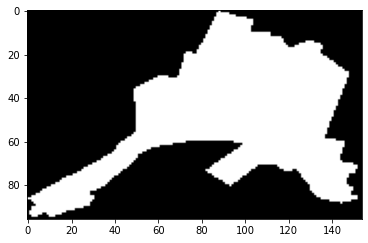

(4, 96, 154, 6, 6)
writing samples 5411


100%|██████████| 5411/5411 [00:00<00:00, 11817.30it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220314T082719_20220314T083610_T37TCN_size_6_volnovskha_info.pth


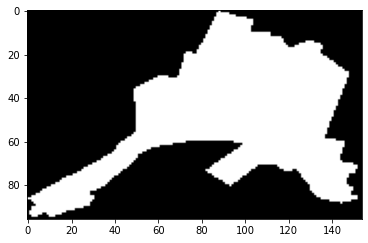

(4, 96, 154, 6, 6)
writing samples 5411


100%|██████████| 5411/5411 [00:00<00:00, 11790.32it/s]


/data4/Ukraine_img/volnovskha/20220319T082651_20220319T083304_T37TCN_size_6_volnovskha_info.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


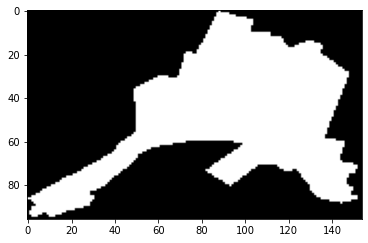

(4, 96, 154, 6, 6)
writing samples 5411


100%|██████████| 5411/5411 [00:00<00:00, 11660.31it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220324T082609_20220324T083426_T37TCN_size_6_volnovskha_info.pth


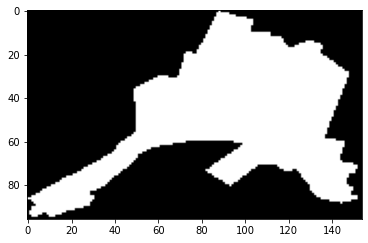

(4, 96, 154, 6, 6)
writing samples 5411


100%|██████████| 5411/5411 [00:00<00:00, 11513.07it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220329T082601_20220329T083216_T37TCN_size_6_volnovskha_info.pth


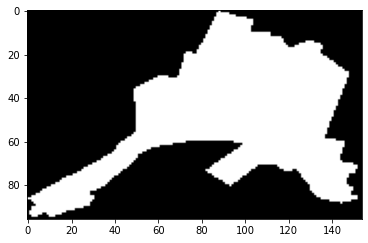

(4, 96, 154, 6, 6)
writing samples 5411


100%|██████████| 5411/5411 [00:00<00:00, 11604.14it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220403T082559_20220403T083553_T37TCN_size_6_volnovskha_info.pth


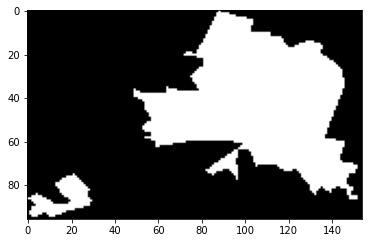

(4, 96, 154, 6, 6)
writing samples 4413


100%|██████████| 4413/4413 [00:00<00:00, 11497.60it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220428T082611_20220428T083305_T37TCN_size_6_volnovskha_info.pth


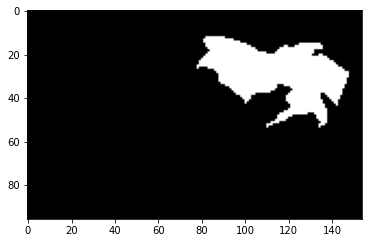

(4, 96, 154, 6, 6)
writing samples 1275


100%|██████████| 1275/1275 [00:00<00:00, 10735.54it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220503T082559_20220503T083512_T37TCN_size_6_volnovskha_info.pth


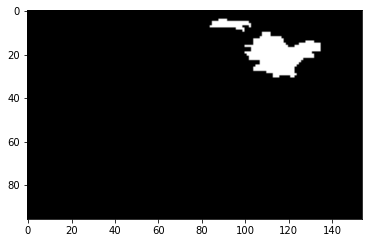

(4, 96, 154, 6, 6)
writing samples 367


100%|██████████| 367/367 [00:00<00:00, 5241.29it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




B
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07_size_6_dammask.pth.tar


B-Z
loading mask: B
/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07_size_6_dammask.pth.tar
load img: B-Z
['/data4/Ukraine_img/volnovskha/20220508T082611_20220508T083304_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220513T082559_20220513T082940_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220528T082611_20220528T083641_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220602T082559_20220602T082807_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220607T082611_20220607T083435_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220612T082609_20220612T082840_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220617T082611_20220617T083253_T37TCN_size_6_volnovskha_info.pth', '/data4/Ukraine_img/volnovskha/20220622T082609_2

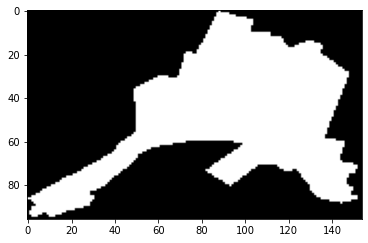

(4, 96, 154, 6, 6)
writing samples 202


100%|██████████| 202/202 [00:00<00:00, 6101.51it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220513T082559_20220513T082940_T37TCN_size_6_volnovskha_info.pth


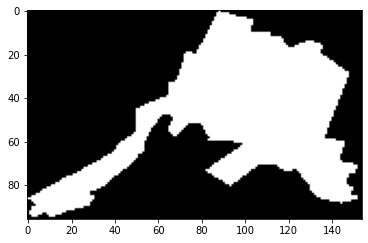

(4, 96, 154, 6, 6)
writing samples 191


100%|██████████| 191/191 [00:00<00:00, 5878.82it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220528T082611_20220528T083641_T37TCN_size_6_volnovskha_info.pth


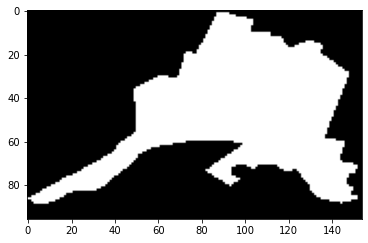

(4, 96, 154, 6, 6)
writing samples 201


100%|██████████| 201/201 [00:00<00:00, 5535.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220602T082559_20220602T082807_T37TCN_size_6_volnovskha_info.pth


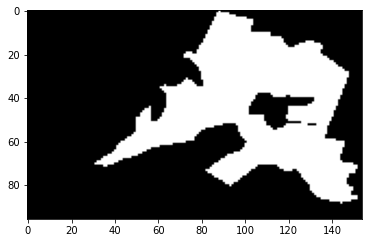

(4, 96, 154, 6, 6)
writing samples 161


100%|██████████| 161/161 [00:00<00:00, 5587.13it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220607T082611_20220607T083435_T37TCN_size_6_volnovskha_info.pth


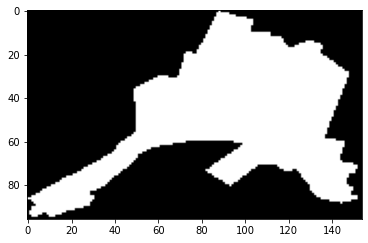

(4, 96, 154, 6, 6)
writing samples 202


100%|██████████| 202/202 [00:00<00:00, 5750.50it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220612T082609_20220612T082840_T37TCN_size_6_volnovskha_info.pth


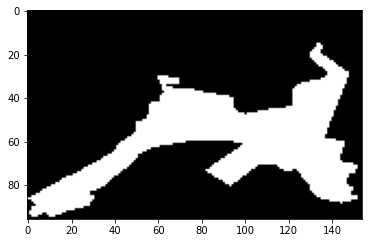

(4, 96, 154, 6, 6)
writing samples 83


100%|██████████| 83/83 [00:00<00:00, 4177.64it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220617T082611_20220617T083253_T37TCN_size_6_volnovskha_info.pth


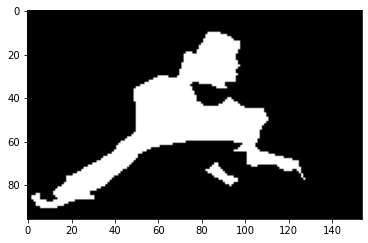

(4, 96, 154, 6, 6)
writing samples 85


100%|██████████| 85/85 [00:00<00:00, 4481.21it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/data4/Ukraine_img/volnovskha/20220622T082609_20220622T082834_T37TCN_size_6_volnovskha_info.pth


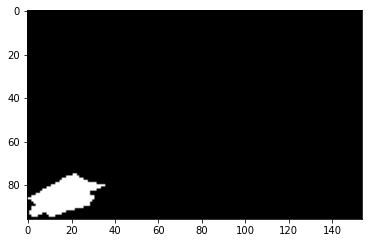

(4, 96, 154, 6, 6)
writing samples 2


100%|██████████| 2/2 [00:00<00:00, 1638.40it/s]


In [62]:
city=cities[2]
cities=dammasks_path.keys()
for city in cities:
    print('-------------------------------------')
    cityimg_pathes10=img_pathes[city]

    # print(city)
    masks10=dammasks_path[city]

    # print(masks)
    k_interval=list(cityimg_pathes10.keys())

    print(k_interval)
    k_interval.remove('A')
    for k_ in k_interval:
        print()
        print()
        print(k_)
        if len(k_)==1:
            print('loading mask:',k_)
            print(masks10[k_])
            mask_now=torch.load(masks10[k_])
            mask_before=None
            mask_after=None
        else:
            if 'A' in k_:
                print('loading mask:',k_[2])
                print(masks10[k_[2]])
                mask_now=None
                mask_before=None
                mask_after=torch.load(masks10[k_[2]])
            elif 'Z' in k_:
                print('loading mask:',k_[0])
                print(masks10[k_[0]])
                mask_now=None
                mask_before=torch.load(masks10[k_[0]])
                mask_after=None
            else:
                print('loading mask:',k_[0],'and',k_[2])
                print(masks10[k_[0]])
                print(masks10[k_[2]])
                mask_now=None
                mask_before=torch.load(masks10[k_[0]])
                mask_after=torch.load(masks10[k_[2]])  
        pre10_path=cityimg_pathes10['A'][0]
        pre_info=torch.load(pre10_path)
        pre_img=[pre_info['img10'],pre_info['img20']]
        post10_pathes=cityimg_pathes10[k_]
        if len(post10_pathes)==0:
            continue
        post10_pathes.sort()
        print('load img:',k_)
        print(post10_pathes)
        for post10_path in post10_pathes:
            print(post10_path)
            post_info=torch.load(post10_path)
            post_img=[post_info['img10'],post_info['img20']]
            plt.imshow(post_img[0][:3,:,:,1,1].transpose((1,2,0)))
            plt.show()
            samples,zz=get_samples(pre_img,post_img,mask_after,mask_now,mask_before)
            print('writing samples',len(samples))
            time.sleep(2)

            samples_root=f'/ssd/hk/Ukraine_samples/samplesv2/samples_volnovskha/'
            img_id=os.path.basename(post10_path).split('_size')[0].replace('_','-')

            samples_pathes=[samples_root+f'{city}_{img_id}_{str(i[0][0]).zfill(3)+str(i[0][1]).zfill(3)}.pth' for i in samples]
            info=[]

            for i in tqdm(range(len(samples))):
                    # '5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6'
                    info.append([samples_pathes[i],samples[i][0],samples[i][1]])
                    torch.save(samples[i],samples_pathes[i])
            info_dict={'readme':'4个字段\n 1:pre图像路径\n 2:post图像路径\n 3:图像坐标\n 4:损毁信息\n 损毁信息有5层\n 5层分别为完全 严重 中等 以及损毁得分和类型\n得分:完全算6分 严重算3分 中等算1分 其他0分\n类型0:得分0 类型1:得分1-5 类型2:得分大于6', 'info':info}
            torch.save(info_dict,f'/ssd/hk/Ukraine_samples/samplesv2/{city}_{img_id}_samples_info.pth')
        # if post10_path=='/data4/Ukraine_img/U_band2348/20220314T082719_20220314T083610_T37TDN_cut_reprojection_size_6_area1_info.pth':
        #     raise

In [52]:
cities[2]

'volnovskha'

# 创建samples_slip文件

volnovskha
/data4/Ukraine_img/volnovskha/20210910T082601_20210910T083119_T37TCN_size_6_volnovskha_info.pth
t:3928   v:1685


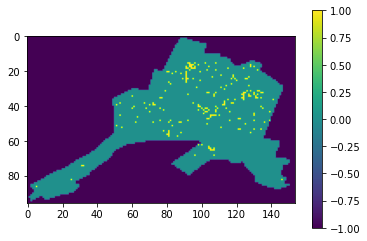

In [63]:
size=6
city='volnovskha'
print(city)
if 'C' in list(dammasks_path[city].keys()):
    dammask_path=dammasks_path[city]['C']
else:
    dammask_path=dammasks_path[city]['B']

dammask=torch.load(dammask_path)['mask'][0]
# plt.imshow(dammask)
# plt.show()
mask_path=img_pathes[city]['A'][0]
print(mask_path)
mask=torch.load(mask_path)['img10'][0]
mask[mask>0]=1
# plt.imshow(mask[:,:,0,0])
# plt.show()
shape=mask.shape




sample_mask=np.zeros((shape[0],shape[1]))
sample_p=[]
sample_n=[]
for x in range(shape[0]):
    for y in range(shape[1]):
        if dammask[x,y]>0:
            sample_mask[x,y]=1
        if (mask[x,y]==0).any() and (mask[x,y]==0).any():
            sample_mask[x,y]=-1
        if sample_mask[x,y]==1:
            sample_p.append([x,y])
        elif sample_mask[x,y]==0:
            sample_n.append([x,y])

p_coord=[str(i[0]).zfill(3)+str(i[1]).zfill(3) for i in sample_p]
n_coord=[str(i[0]).zfill(3)+str(i[1]).zfill(3) for i in sample_n]
random.shuffle(p_coord)
random.shuffle(n_coord)
p_t_coord=p_coord[:int(len(p_coord)*0.7)]
p_v_coord=p_coord[int(len(p_coord)*0.7):]
n_t_coord=n_coord[:int(len(n_coord)*0.7)]
n_v_coord=n_coord[int(len(n_coord)*0.7):]
t=p_t_coord+n_t_coord
v=p_v_coord+n_v_coord
random.shuffle(t)
random.shuffle(v)
print(f't:{len(t)}   v:{len(v)}')
torch.save(t,f'/ssd/hk/Ukraine_samples/coords_splitv2/{city}_train.pth')
torch.save(v,f'/ssd/hk/Ukraine_samples/coords_splitv2/{city}_val.pth')
# plt.figure(figsize=(15,15))
plt.imshow(sample_mask)
plt.colorbar()
plt.show()



In [64]:
coords_v=torch.load('/ssd/hk/Ukraine_samples/coords_splitv2/volnovskha_val.pth')
coords_t=torch.load('/ssd/hk/Ukraine_samples/coords_splitv2/volnovskha_train.pth')

In [65]:
def match(string,input_list):
    new_data_list=[i for i in input_list if  re.match(string, i[0]) != None]
    return new_data_list
t=[]
v=[]
city_sample=[]
for i in glob('/ssd/hk/Ukraine_samples/coords_splitv2/volnovskha*train.pth'):
    t+=torch.load(i)
    v+=torch.load(i.replace('train','val'))
print(len(t),len(v))
for i in glob('/ssd/hk/Ukraine_samples/samplesv2/volnovskha*.pth'):
    city_sample+=torch.load(i)['info']
print(len(city_sample))

for i in range(len(city_sample)):
    if len(city_sample[i][2])==2:
        if city_sample[i][2][0] is not None:
            city_sample[i][2]=city_sample[i][2][0]
        else:
            city_sample[i][2]=city_sample[i][2][1]
city_pathes=[[i[0],'n'] if i[2][0]==0 else [i[0],'p'] for i in city_sample]
random.shuffle(city_pathes)
import re
city_coord_sample={}
city_coord_sample['train']={}
city_coord_sample['val']={}
print('match train')
time.sleep(2)
for i in tqdm(t):
    a=match(f'.*{i}.pth',city_pathes)
    a.sort()
    city_coord_sample['train'][i]=a
print('match val')
time.sleep(2)
for i in tqdm(v):
    a=match(f'.*{i}.pth',city_pathes)
    a.sort()
    city_coord_sample['val'][i]=a
torch.save(city_coord_sample,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/volnovskha/samples.pth') 



t=[]
for i in city_coord_sample['train'].keys():
    t+=city_coord_sample['train'][i]
v=[]
for i in city_coord_sample['val'].keys():
    v+=city_coord_sample['val'][i]
random.shuffle(t)
random.shuffle(v)
# torch.save(t,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/train.pth') 
# torch.save(v,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/val.pth') 

3928 1685
34237
match train


100%|██████████| 3928/3928 [02:00<00:00, 32.59it/s]


match val


100%|██████████| 1685/1685 [00:51<00:00, 32.70it/s]


In [66]:
torch.save(t,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/volnovskha/train.pth') 
torch.save(v,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/volnovskha/val.pth') 

In [67]:
print(len(t))
len([i  for i in t if i[1]=='p'])


23960


789

In [68]:
print(len(v))
len([i  for i in v if i[1]=='p'])

10277


338

In [69]:
import gdal
import torch
s=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/volnovskha/samples.pth')
tt=[]
for i in s['train'].keys():
    t_p=[j[0] for j in s['train'][i]]+[None]*(20-len(s['train'][i]))
    t_l=[j[1] for j in s['train'][i]]+[None]*(20-len(s['train'][i]))
    tt.append([t_p,t_l])
vv=[]
for i in s['val'].keys():
    t_p=[j[0] for j in s['val'][i]]+[None]*(20-len(s['val'][i]))
    t_l=[j[1] for j in s['val'][i]]+[None]*(20-len(s['val'][i]))
    vv.append([t_p,t_l])
print(len(tt),len(vv))
torch.save(tt,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/volnovskha/train.pth')
torch.save(vv,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/volnovskha/val.pth')

3928 1685


In [229]:
tt=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_Azovstal_v3/train.pth')+torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/train.pth')
vv=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_Azovstal_v3/val.pth')+torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/val.pth')
random.shuffle(tt)
random.shuffle(vv)
torch.save(tt,'/ssd/hk/Ukraine_samples/split_coordv2_all_v3/train.pth')
torch.save(vv,'/ssd/hk/Ukraine_samples/split_coordv2_all_v3/val.pth')

In [244]:
k=[]
for i in tt:
    p=[j for j in i[0] if j is not None]
    l=[j for j in i[1] if j is not None]
    for j in range(len(p)):
        k.append([p[j],l[j]])
random.shuffle(k)
torch.save(k,'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/M/train.pth')

In [246]:
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/ML/train.pth')))
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/Azovstal/train.pth')))
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/M/train.pth')))
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/ML/val.pth')))
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/Azovstal/val.pth')))
print(len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/M/val.pth')))

49862
10343
60205
21301
4437
25738


In [242]:
49862+10343

60205

In [262]:
f=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Azovstal/train.pth')
print(len(f))
k=[]
for i in f:
    z=[j for j in i[0] if j is not None]
    if len(z)>0:
        k.append(i)
print(len(k))
f=torch.save(k,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Azovstal/train.pth')

2561
2561


In [173]:
ttt2=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Sievierodoetsk/train.pth')

In [175]:
aa=[]
for i in ttt2:
    if i[1][0]=='p':
        aa.append(i)


In [163]:
aa2=[]
for i in ttt:
    if i[1][0]=='p':
        aa2.append(i)


In [177]:
print(len(ttt2),len(aa))

6438 54


In [178]:
print(len(ttt),len(aa2))

5429 227


In [2]:
os.listdir('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MSRV')

['val.pth', 'train.pth']

In [18]:
import torch
import random
cs=['M']
for c in cs:
    if not os.path.exists(f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/{c}/'):
        os.mkdir(f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/{c}/')
    for f in ['val2','train2']:
        t=torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/{c}/{f}.pth')
        tv2=[]
        for j in t:
            p,l=j
            v2=[[p[i],l[i]] for i in range(len(p)) if p[i] is not None ]
            tv2+=(v2)
        random.shuffle(tv2)
        torch.save(tv2,f'/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/{c}/{f}.pth')

In [3]:
os.listdir('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/M/')

['val.pth', 'samples2.pth', 'val2.pth', 'samples.pth', 'train.pth']

In [90]:
cs=['M','Rubizhne','Sievierodoetsk','volnovskha']
scs='MRSV'
aaaa=[]
if not os.path.exists(f'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/{scs}/'):
    os.mkdir(f'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/{scs}/')
for c in cs:
    aaaa+=torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/{c}/val.pth')

random.shuffle(aaaa)
torch.save(aaaa,f'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/{scs}/val.pth')
aaaa=[]
for c in cs:
    aaaa+=torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/{c}/train.pth')

random.shuffle(aaaa)

torch.save(aaaa,f'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/{scs}/train.pth')

In [87]:
os.mkdir(f'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/{scs}/')

In [187]:
aa3=[]
for i in A:
    if i[1][0]=='p':
        aa3.append(i)

In [94]:
aaaa=torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MRV/val.pth')+torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MSRV/train.pth')
random.shuffle(aaaa)
torch.save(aaaa,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MRV/samples.pth')

In [161]:
s=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MSR/samples2.pth')

In [202]:
len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/ML/train.pth'))

10318

In [203]:
len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/M/train.pth'))

12877

In [208]:
len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Azovstal/train.pth'))

2561

In [205]:
len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/MLR/train.pth'))

15747

In [207]:
len(torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Rubizhne/train.pth'))

5429

In [266]:
a=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/Sievierodoetsk/train.pth')

In [286]:
a=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Rubizhne/train.pth')+torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Rubizhne/val.pth')
random.shuffle(a)
torch.save(a,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/Rubizhne/samples.pth')

In [174]:
aa3=[]
for i in s:
    if 'p' in i[1]:
        aa3.append(i)
print(len(aa3))

634


In [175]:
len(s)/634

45.22397476340694

In [110]:
len(s)/483

51.22981366459627

In [268]:
252/len(a)

0.0037936952398157347

In [230]:
30/2561

0.011714174150722375

In [239]:
np.array([1 if i[1]=='p' else 0 for i in a]).sum()

1171

In [240]:
len(a)

49862

In [241]:
1171/49862

0.023484818097950343

In [242]:
(1-0.023484818097950343)/0.023484818097950343

41.58070025619129

In [13]:
len(os.listdir('/data4/Ukraine_img/volnovskha/'))

17

In [114]:
os.listdir('/ssd/hk/Ukraine_samples/split_coordv2_v2/cities/M/')

['val.pth', 'train.pth']

In [9]:
s=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/M/train.pth')

In [10]:
s2=[]
for k in s:
    a_id=[]
    for i in k[0]:
        
        if i is None:
            a_id.append(0)
        elif 'area' in i and '20220508T' in i:
            a_id.append(1)
        else:
            a_id.append(0)
    k2=[[k[0][i] for i in range(len(k[0])) if a_id[i]==0],[k[1][i] for i in range(len(k[0])) if a_id[i]==0]]
    k2[0]+=[None]*(20-len(k2[0]))
    k2[1]+=[None]*(20-len(k2[1]))
    s2.append(k2)
s3=[]
for i in s2:
    z=[j for j in i[0] if j is not None]
    if len(z)==0:
        print(i)
    else:
        s3.append(i)
torch.save(s3,'/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/M/train2.pth') 

In [20]:
def get_p(s,version):
    if version=='3':
        aa3=[]
        for i in s:
            if 'p' in i[1]:
                aa3.append(i)
        return len(aa3)
    else:
        aa2=[1 if i[1]=='p' else 0 for i in s]
        return np.array(aa2).sum()

    # print(len(aa3))

In [125]:
a[0][0]

['/ssd/hk/Ukraine_samples/samplesv2/samples/area2_20220314T082719-20220314T083610-T37TCN2_167312.pth',
 '/ssd/hk/Ukraine_samples/samplesv2/samples/area2_20220319T082651-20220319T083304-T37TCN2_167312.pth',
 '/ssd/hk/Ukraine_samples/samplesv2/samples/area2_20220324T082609-20220324T083426-T37TCN2_167312.pth',
 '/ssd/hk/Ukraine_samples/samplesv2/samples/area2_20220329T082601-20220329T083216-T37TCN2_167312.pth',
 '/ssd/hk/Ukraine_samples/samplesv2/samples/area2_20220508T082611-20220508T083304-T37TCN2_167312.pth',
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [23]:
import torch
cs=['M','Rubizhne','Sievierodoetsk','volnovskha']
version='2'
for c in cs:
    if c=='M':

        t=torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v{version}/cities/{c}/train2.pth')
        v=torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v{version}/cities/{c}/val2.pth')
    else:
        t=torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v{version}/cities/{c}/train.pth')
        v=torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v{version}/cities/{c}/val.pth')
    print(len(t),len(v),len(t+v),get_p(t+v,'2')/len(t+v))
t=torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v{version}/cities/MSRV/train.pth')
v=torch.load(f'/ssd/hk/Ukraine_samples/split_coordv2_v{version}/cities/MSRV/val.pth')
print(len(t),len(v),len(t+v),get_p(t+v,'2')/len(t+v))

53530 22878 76408 0.024146686210867973
57269 24573 81842 0.02497495173627233
66426 28463 94889 0.0038676769699332904
23960 10277 34237 0.03291760376201186
201185 86191 287376 0.018731557262958633


In [22]:
import numpy as np

In [13]:
5524+2328+2761+1685

12298

In [17]:
s=torch.load('/ssd/hk/Ukraine_samples/split_coordv2_v3/cities/M/train.pth')
ss=[]
for i in ss:
    for 

In [15]:
import geopandas as gpd
ps_path=['/home/hk/python_script/Ukraine/data/UNOSAT/Sievierodonetsk_CDA_20220725/Sievierodonetsk_B_2022-07-25.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/Rubizhne_CDA_20220709/Rubizhne_B_2022-07-09.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/volnovakha/Volnovakha_B_2022-05-07.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_B_2022-04-25.shp',
'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C_2022-05-07.shp'
]
f=gpd.read_file(ps_path[0])
print('S',len(f[f['DmgCls']=='Destroyed']))
f=gpd.read_file(ps_path[1])
print('R',len(f[f['DmgCls']=='Destroyed']))
f=gpd.read_file(ps_path[2])
print('V',len(f[f['DmgCls']=='Destroyed']))
f=gpd.read_file(ps_path[3])
print('A',len(f[f['DmgCls']=='Destroyed']))
f=gpd.read_file(ps_path[4])
print('L',len(f[f['DmgCls']=='Destroyed']))

S 92
R 488
V 264
A 50
L 312


In [21]:
import matplotlib.pyplot as plt
cities=['S','R','V','A','L']
for i in range(5):
    f=gpd.read_file(ps_path[i])
    f[f['DmgCls']=='Destroyed'].to_file(f'/home/hk/python_script/Ukraine/data/UNOSAT/Destroyed/{cities[i]}.shp')
    plt.show()


In [11]:
from glob import glob
glob('/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/*.shp')

['/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Steelmills.shp',
 '/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_ROI.shp',
 '/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_B_2022-04-25.shp',
 '/home/hk/python_script/Ukraine/data/UNOSAT/Azovstal_0425/Azovstal_25April2022_CDA.shp']

In [ ]:
'/home/hk/python_script/Ukraine/data/UNOSAT/U/Livoberezhyny_C_2022-05-07.shp'